In [7]:
# Import Libs
import ast
import math
import itertools
import operator
import numpy as np
import string
import random
import string
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import seaborn as sns

In [ ]:
data_recipes=pd.read_csv('data/RAW_recipes.csv', index_col=1, usecols=['id','name','ingredients']) 
data_recipes.to_csv('data/ingredient_graph.csv')

In [5]:
def ingredient_stat(data):
    """
    count ingredient and build connections
    :param data: dataframe of ingredients
    :return: graph
    """

    # count ingredient
    ingredients = data['ingredients'].tolist()
    food_dict = {}
    for ingredient in ingredients:
        if isinstance(ingredient, str) and ingredient.startswith('[') and ingredient.endswith(']'):
            list_data = ast.literal_eval(ingredient)
            for item in list_data:
                if item in food_dict:
                    food_dict[item] += 1
                else:
                    food_dict[item] = 1
    sorted_food_dict = dict(sorted(food_dict.items(), key=operator.itemgetter(1), reverse=True)) 
    return sorted_food_dict

success write dict to json: data/ingredient_graph.json
data/ingredient_graph.json successfully loaded!
success write dict to json: data/high_freq_food_dict.json
<class 'dict'>


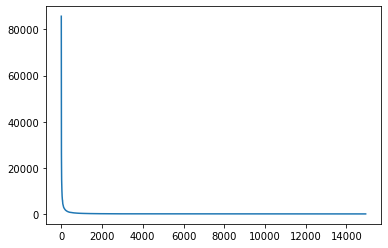

In [6]:
data = pd.read_csv('data/ingredient_graph.csv', index_col=0)
food_dict = ingredient_stat(data)
save_dict_to_json(food_dict, 'data/ingredient_graph.json')
food_dict = read_dict_from_json('data/ingredient_graph.json')

high_freq_food_dict = {}
for food, freq in food_dict.items():
    if freq >= 15:
        high_freq_food_dict[food] = freq
save_dict_to_json(high_freq_food_dict, 'data/high_freq_food_dict.json')
print(type(food_dict))
plt.plot(list(food_dict.values()))
plt.show()

In [8]:
high_freq_ingredient = read_dict_from_json('data/high_freq_food_dict.json')

h_food2index = {}
h_index2food = {}

for idx, ingredient in enumerate(high_freq_ingredient.keys()):
    h_food2index[ingredient] = idx
    h_index2food[idx] = ingredient

save_dict_to_json(h_food2index, 'data/h_food2index.json')
save_dict_to_json(h_index2food, 'data/h_index2food.json')

data/high_freq_food_dict.json successfully loaded!
success write dict to json: data/h_food2index.json
success write dict to json: data/h_index2food.json


data/h_food2index.json successfully loaded!
data/h_index2food.json successfully loaded!


In [21]:
def tuple2string(t):
    """
    convert a tuple to a string
    """
    return '{}_{}'.format(t[0], t[1])

def string2tuple(s):
    """
    convert a string to a tuple
    """
    return tuple(s.split('_'))


def build_connection(ing_list):
    """
    all effective ingredient in a dish will be connected
    :param ing_list: list of ingredients
    :return: a list of two-element tuples
    """
    assert isinstance(ing_list, list)

    ing_idx_list = []
    for i in ing_list:
        if i in h_food2index:
            ing_idx_list.append(h_food2index[i])

    if len(ing_idx_list) < 2: return []
    # add every two item index in the list to a two-element tuple
    connection_lists = list(itertools.combinations(ing_idx_list, 2))
    return connection_lists

file_path = 'data/ingredient_graph.csv'
df = pd.read_csv(file_path, index_col=0)
h_food2index = read_dict_from_json('data/h_food2index.json')
h_index2food = read_dict_from_json('data/h_index2food.json')
all_connection_dict = {}

for idx, row in df.iterrows():
    if isinstance(row['ingredients'], str) and row['ingredients'].startswith('[') and row['ingredients'].endswith(']'):
        food_ingredient = ast.literal_eval(row['ingredients'])
        assert isinstance(food_ingredient, list), 'ingredient is not a list'
        connected_ing = build_connection(food_ingredient)
        for pair in connected_ing:
            pair_s = tuple2string(pair)
            if pair_s in all_connection_dict:
                all_connection_dict[pair_s] += 1
            else:
                all_connection_dict[pair_s] = 1

data/h_food2index.json successfully loaded!
data/h_index2food.json successfully loaded!


In [22]:
save_dict_to_json(all_connection_dict, 'data/all_connection_dict.json')

all_connection_dict = read_dict_from_json('data/all_connection_dict.json')
all_connection_list = list(all_connection_dict.keys())
ing_connection_list = [string2tuple(pair) for pair in all_connection_list]
idx_connection_list = list(all_connection_dict.values())

sorted_connection_dict = dict(sorted(all_connection_dict.items(), key=operator.itemgetter(1), reverse=True)) 
save_dict_to_json(sorted_connection_dict, 'data/sorted_all_connection_dict.json')

success write dict to json: data/all_connection_dict.json
data/all_connection_dict.json successfully loaded!
success write dict to json: data/sorted_all_connection_dict.json


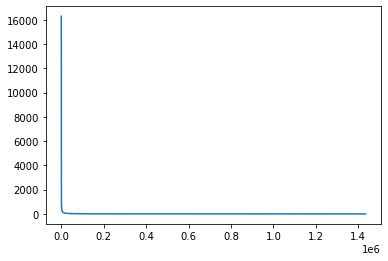

In [23]:
plt.plot(list(sorted_connection_dict.values()))
plt.show()

In [24]:
def get_connection_weight(i, j):
    """
    get the weight of the connection between i and j
    :param i: the first node (int)
    :param j: the second node (int)
    :return: (i, j, weight)
    """
    assert i != j
    assert isinstance(i, int)
    assert isinstance(j, int)
    freq = all_connection_dict['{}_{}'.format(i, j)]
    return (i, j, np.log(freq))


In [28]:
index2food = read_dict_from_json('data/h_index2food.json')
# all_idx_list, all_food_list = list(index2food.keys()), list(index2food.values())
all_connection_dict = read_dict_from_json('data/sorted_all_connection_dict.json')
all_connection_list = list(all_connection_dict.keys())
idx_connection_list = [string2tuple(pair) for pair in all_connection_list[500:700]]
idx_connection_list = [get_connection_weight(int(x1), int(x2)) for x1, x2 in idx_connection_list]
# print(idx_connection_list)

x = set()
for pair in idx_connection_list:
    if pair[0] not in x:
        x.add(pair[0])
    if pair[1] not in x:
        x.add(pair[1]) 

all_idx_list = list(x)
all_food_list = [index2food[str(idx)] for idx in all_idx_list]


data/h_index2food.json successfully loaded!
data/sorted_all_connection_dict.json successfully loaded!


In [33]:
from pyvis.network import Network
import numpy as np

net = Network(notebook=True)
net.add_nodes(all_idx_list, label=all_food_list)
net.add_edges(idx_connection_list)
net.show_buttons(filter_=['physics'])

net.show('food_connection.html')


# Now we will start to work on ingredient's embeddings

In [34]:
import pdb
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import Node2Vec 
from utils import *
# from draw_graph import get_connection_weight

In [35]:
index2food = read_dict_from_json('data/h_index2food.json')
all_connection_dict = read_dict_from_json('data/sorted_all_connection_dict.json')
all_connection_list = list(all_connection_dict.keys())
idx_connection_list = [string2tuple(pair) for pair in all_connection_list]
idx_connection_list = [[int(x1), int(x2)] for x1, x2 in idx_connection_list]

edge_index = torch.tensor(idx_connection_list, dtype=torch.long)
edge_index = torch.t(edge_index)
edge_index_ = edge_index[[1, 0], :]
new_edge_index = torch.concat((edge_index, edge_index_), dim=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(edge_index=new_edge_index, embedding_dim=64, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

nodes = edge_index.numpy()
nodes = np.unique(list(nodes[0, :]) + list(nodes[1, :]))
print(nodes.shape)

# np.random.seed(10)
# # get the nodes
# np.random.shuffle(nodes) # shuffle node order
# print(len(nodes))

data/h_index2food.json successfully loaded!
data/sorted_all_connection_dict.json successfully loaded!
(5031,)


In [36]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]

print(len(train_set), len(test_set), len(val_set))
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
data = Data(edge_index=new_edge_index)
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc

for epoch in range(1, 101):
    loss = train()
    # acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')


3521 755 755
Epoch: 10, Loss: 1.2207
Epoch: 20, Loss: 1.1792
Epoch: 30, Loss: 1.1750
Epoch: 40, Loss: 1.1732
Epoch: 50, Loss: 1.1718
Epoch: 60, Loss: 1.1727
Epoch: 70, Loss: 1.1713
Epoch: 80, Loss: 1.1707
Epoch: 90, Loss: 1.1691
Epoch: 100, Loss: 1.1685


(5031, 2)


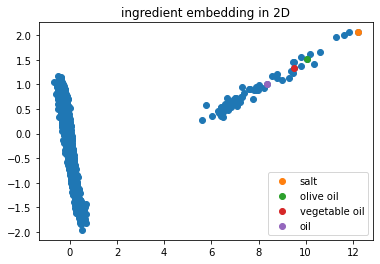

In [37]:
z = model()
# from tensor to numpy
emb_64 = z.detach().cpu().numpy()

from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_64)
print(emb2d.shape)

plt.title("ingredient embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])

show_list = [0, 6, 20, 28]

# for idx, ing in enumerate(list(index2food.values())[show_list]):

for idx in show_list:
    ing = index2food[str(idx)]
    plt.scatter(emb2d[int(idx), 0],emb2d[int(idx), 1], label=ing)
    plt.legend()

plt.savefig('ingredient_embedding_2d.png')
plt.show()